## GB_FX Price only Quarterly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 1999-01-04 → 2024-12-31 | n=6782
Data (D): 1999-01-04 → 2024-12-31 | n=9494

Dropped quarters and reasons:
  1999Q1: no_cut_in_prev_quarter
  1999Q2: hist<400
  1999Q3: hist<400
  1999Q4: hist<400
  2000Q1: hist<400

=== Model performance (quarterly mean, EUR/NOK) ===
Observations: 99
RMSE (level): 0.248235
MAE  (level): 0.164538
Directional accuracy: 72/98 (73.5%)

=== Diebold–Mariano vs Random Walk ===
Loss: MSE | horizon h=1
DM-statistic: 0.1933
p-value     : 0.8467


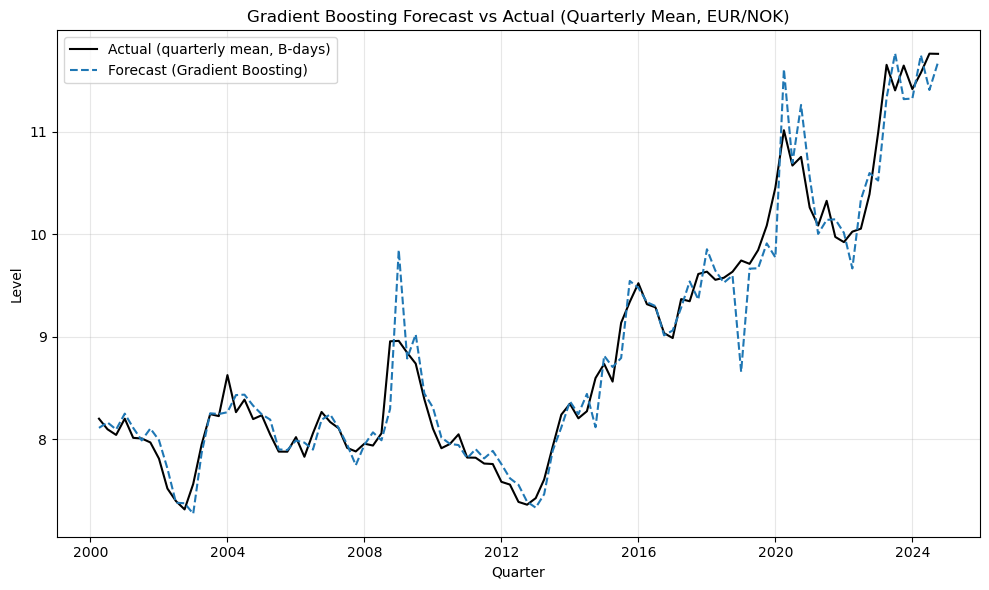

Saved: GB_Quarterly.png
Saved: GB_Quarterly.pdf


In [2]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (quarterly, levels), point forecast only
# PARALLEL OUTER LOOP
# - Data: GitHub CSV (semicolon-separated; decimal comma), forward-filled to daily
# - Cut: last business day of previous quarter
# - Model: GradientBoostingRegressor on daily lag features
# - Forecast: recursive daily next-quarter -> aggregate to quarterly mean over business days
# - Metrics: Observations, RMSE, MAE, Directional accuracy
# - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
# - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/Data_MasterOppgave/"
        "refs/heads/main/EURNOK/EUR_NOK_NorgesBank.csv"
    )
    q_freq: str = "Q-DEC"      # Quarterly evaluation frequency
    min_hist_days: int = 400   # GB needs more history than high-frequency models
    max_lags: int = 20         # Number of daily lags used as features

    # Gradient Boosting hyperparameters
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_Quarterly.png"
    fig_pdf: str = "GB_Quarterly.pdf"

CFG = Config()

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.Series]:
    """
    Load Norges Bank CSV (semicolon-separated; decimal comma) with columns TIME_PERIOD, OBS_VALUE.
    Returns:
      S_b: Business-day (B) series with ffill (used for cuts and quarterly ground truth)
      S_d: Daily (D) series with ffill (model inputs and daily forecasts)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=';', encoding='utf-8-sig', decimal=',')

    required_cols = {"TIME_PERIOD", "OBS_VALUE"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (raw[['TIME_PERIOD', 'OBS_VALUE']]
          .rename(columns={'OBS_VALUE': 'EUR_NOK'})
          .assign(TIME_PERIOD=lambda x: pd.to_datetime(x['TIME_PERIOD'], errors='coerce'))
          .dropna(subset=['TIME_PERIOD', 'EUR_NOK'])
          .sort_values('TIME_PERIOD')
          .set_index('TIME_PERIOD'))

    # Business-day series (truth / aggregation base)
    S_b = df['EUR_NOK'].asfreq('B').ffill().astype(float)
    S_b.name = 'EUR_NOK'

    # Daily series (model inputs / daily forecasts)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
    S_d = df['EUR_NOK'].reindex(full_idx).ffill().astype(float)
    S_d.index.name = 'DATE'
    S_d.name = 'EUR_NOK'
    return S_b, S_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (lags)
# -----------------------------
def make_lag_matrix(y: pd.Series, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct X and y_target for one-step ahead forecasting:
      X_t = [y_{t-1}, ..., y_{t-max_lags}]
      y_target = y_t
    """
    df = pd.DataFrame({'y': y})
    for k in range(1, max_lags + 1):
        df[f'lag{k}'] = df['y'].shift(k)
    df = df.dropna()
    X = df[[f'lag{k}' for k in range(1, max_lags + 1)]].values
    y_target = df['y'].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(y_hist_daily: pd.Series) -> GradientBoostingRegressor:
    """Fit Gradient Boosting for one-step ahead daily prediction."""
    X, y_target = make_lag_matrix(y_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, y_hist_daily: pd.Series, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively:
      - start from last max_lags observed values
      - each step uses previous predicted value as newest lag
    """
    hist = y_hist_daily.values.tolist()
    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")
        x = np.array(hist[-CFG.max_lags:][::-1], dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)
        hist.append(yhat)
    return pd.Series(preds)

# -----------------------------
# Quarterly walk-forward using GB (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_quarterly_parallel(
    S_b: pd.Series,
    S_d: pd.Series,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit GB on daily history up to cut
      - recursively forecast full calendar quarter at daily frequency
      - aggregate to business-day quarterly mean and compare to truth

    Outer loop is parallelized: each quarter is computed independently.
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # Business days inside target quarter
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # Horizon = full calendar quarter length (inclusive)
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0:
            return (str(q), None, f"horizon_invalid(H={H})")

        # Fit model on daily history up to cut
        model = fit_gb_one_step(hist_d)

        # Recursive daily forecast for next quarter
        pf = recursive_daily_forecast(model, hist_d, H)

        # Index daily forecasts from cut+1 over H calendar days
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq='D')
        pred_daily = pd.Series(pf.values, index=f_idx, name='point')

        # Aggregate forecast to business-day mean over the quarter
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient='index')
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (quarterly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple NW/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Gradient Boosting)")

    plt.title("Gradient Boosting Forecast vs Actual (Quarterly Mean, EUR/NOK)")
    plt.xlabel("Quarter")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, S_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Quarterly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_quarterly_parallel(S_b, S_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
